# Analise de sentimentos do twitter

### Passos a seguir:

* 1 - Compreender a declaração do problema
* 2 - Pré-processamento e Limpeza de Tweets
    * 2.1 - Inspeção de dados
    * 2.2 - Limpeza de Dados
* 3 - Geração de histórias e visualização de tweets
* 4 - Extraindo recursos de tweets limpos
    * 4.1 - Bag-of-Words
    * 4.2 - TF-IDF
    * 4.3 - Word2vec
    * 4.4 - Doc2vec
* 5 - Construção de modelo: análise de sentimentos
    * 5.1 - Regressão logística
    * 5.2 - Máquina de vetores de suporte
    * 5.3 - RandomForest
    * 5.4 - XGBoost
* 6 - Ajuste do modelo

### Importando as bibliotecas

In [1]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Algumas configurações adicionais

In [2]:
pd.set_option('display.max_colwidth', 200)

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
%matplotlib inline

### Carregando os dados

In [5]:
train = pd.read_csv('datasets/train_E6oV3lV.csv')

In [6]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [7]:
test = pd.read_csv('datasets/test_tweets_anuFYb8.csv')

In [8]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


### Inspecionando os dados

In [9]:
# Tweets não racistas/sexistas
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [10]:
# Tweets racistas/sexistas
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [11]:
# Dimenção os dados de treino e teste, respectivamente.
train.shape, test.shape

((31962, 3), (17197, 2))

In [12]:
# Distribuição de tweets racista/sexistas<1> e não racistas/sexistas<0>
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**No conjunto de dados de treino, temos 2.242 (~ 7%) tweets rotulados como racistas ou sexistas e 29.720 (~ 93%) tweets rotulados como não racistas / sexistas. Portanto, é um desafio 
de classificação desequilibrado.**

Agora vamos verificar a distribuição do tamanho dos tweets, em termos de palavras, nos dados de trem e teste.

In [13]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

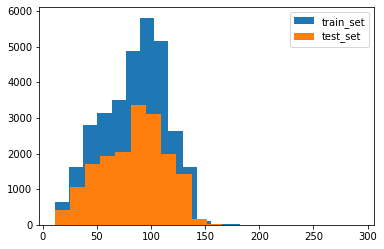

In [14]:
plt.hist(length_train, bins=20, label='train_set')
plt.hist(length_test, bins=20, label='test_set')
plt.legend()
plt.show()

### Pré-processamento dos dados

Em qualquer tarefa de processamento de linguagem natural, a limpeza de dados de texto não processado é uma etapa importante. Ajuda a se livrar das palavras e caracteres indesejados, o que ajuda a obter melhores recursos. Se pularmos esta etapa, há uma chance maior de que você esteja trabalhando com dados barulhentos e inconsistentes. O objetivo desta etapa é limpar os ruídos menos relevantes para encontrar sentimentos de tweets, como pontuação, caracteres especiais, números e termos que não têm muita importância no contexto do texto.

In [15]:
combi = train.append(test, ignore_index=True, sort=True)

In [16]:
combi.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation


**Repare que em algumas linhas da coluna label ficou com o valor NaN, isso se dá pelo fato de o dataset de teste não ter label e quando combinamos os datasets os tweets do dataset de test só tem a coluna tweet(já que ignoramos o index) e não tinha o que preencher no label. Mas não se preocupe, iremos precisar apenas da coluna tweet, pois é exatamente essa coluna que iremos realizar o pré-processamento, e nela não ocorreu nenhum problema. =)**

In [17]:
def remove_pattern(text, pattern):
    ''' 
        Nesta função será passado o texto e a expressão regular 
        para informar que tipo de pré-processamento será feito 
    '''

    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

### Seguiremos as etapas abaixo para limpar os tweets não processados dos dados.

#### 1 - Removeremos as alças do twitter, pois elas já estão mascaradas como @user devido a questões de privacidade. Essas alças do twitter dificilmente fornecem informações sobre a natureza do tweet.
#### 2 - Também nos livraremos das pontuações, números e até caracteres especiais, pois eles não ajudariam a diferenciar diferentes tipos de tweets.
#### 3 - A maioria das palavras menores não agrega muito valor. Por exemplo, 'pdx', 'his', 'all'. Portanto, tentaremos removê-los também de nossos dados.
#### 4 - Por fim, normalizaremos os dados do texto. Por exemplo, reduzir termos como amores, amar e amável à sua palavra base, ou seja, 'amor'. São frequentemente usados ​​no mesmo contexto. Se pudermos reduzi-los à sua raiz, que é "amor". Isso ajudará a reduzir o número total de palavras exclusivas em nossos dados sem perder uma quantidade significativa de informações.

### 1. Removendo alças do Twitter (@user)

Observe que passamos “@ [] *” como padrão para a função remove_pattern. Na verdade, é uma expressão regular que seleciona qualquer palavra que comece com '@'.

In [18]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], '@[\w]*')

In [19]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


### 2. Remoção de pontuações, números e caracteres especiais

Aqui, substituiremos tudo, exceto caracteres e hashtags por espaços. A expressão regular “[^ a-zA-Z #]” significa qualquer coisa, exceto alfabetos e '#'.

In [20]:
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace('[^a-zA-Z#]', ' ')

In [21]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


### 3 - Removendo Palavras Curtas

Temos que ter um pouco de cuidado aqui ao selecionar o tamanho das palavras que queremos remover. Então, eu decidi remover todas as palavras com comprimento 3 ou menos. Por exemplo, termos como "hmm", "oh" são muito pouco úteis. É melhor se livrar deles.

In [22]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join( [w for w in x.split() if len(w) > 3] ))

In [23]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


### 4. Normalização de texto

Aqui vamos usar a função PorterStemmer() do nltk para normalizar os tweets. Mas antes disso teremos que tokenizar os tweets. Tokens são termos ou palavras individuais, e a tokenização é o processo de dividir uma sequência de texto em tokens.

In [24]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

In [25]:
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

**Agora podemos normalizar os tweets tokenizados.**

In [26]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [27]:
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

**Agora iremos transformar o tokenized_tweet em texto novamente.**

In [28]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [29]:
combi['tidy_tweet'] = tokenized_tweet

In [30]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


### Análise exploratória dos dados

**Nesta etapa, exploraremos os tweets limpos. Explorar e visualizar dados, independentemente de seu texto ou qualquer outro dado, é uma etapa essencial para obter insights. Não se limite apenas aos métodos descritos aqui, fique à vontade para explorar os dados o máximo possível.**

**Antes de começarmos a explorar, devemos pensar e fazer perguntas relacionadas aos dados em questão. Algumas perguntas prováveis são as seguintes:**

* Quais são as palavras mais comuns em todo o conjunto de dados?
* Quais são as palavras mais comuns no conjunto de dados para tweets negativos e positivos, respectivamente?
* Quantas hashtags existem em um tweet?
* Quais tendências estão associadas ao meu conjunto de dados?
* Quais tendências estão associadas a algum dos sentimentos? Eles são compatíveis com os sentimentos?

#### A) Compreendendo as palavras comuns usadas nos tweets: WordCloud

Um wordcloud é uma visualização em que as palavras mais frequentes aparecem em tamanho grande e as palavras menos frequentes aparecem em tamanhos menores.

In [31]:
all_words = ' '.join( [text for text in combi['tidy_tweet']] )

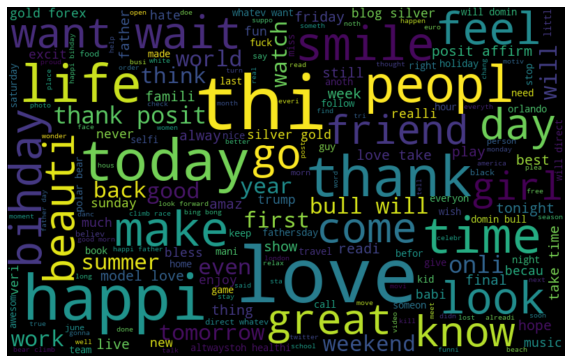

In [32]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Podemos ver que a maioria das palavras é positiva ou neutra. Palavras como amor, ótimo, amigo, vida são as mais frequentes. Não nos dá nenhuma idéia sobre as palavras associadas aos tweets racistas / sexistas. Portanto, traçaremos nuvens de palavras separadas para ambas as classes (racistas / sexistas ou não) em nossos dados de treino.**

#### B) Palavras em tweets não racistas / sexistas

In [33]:
normal_words =  ' '.join( [text for text in combi['tidy_tweet'][combi['label'] == 0]] )

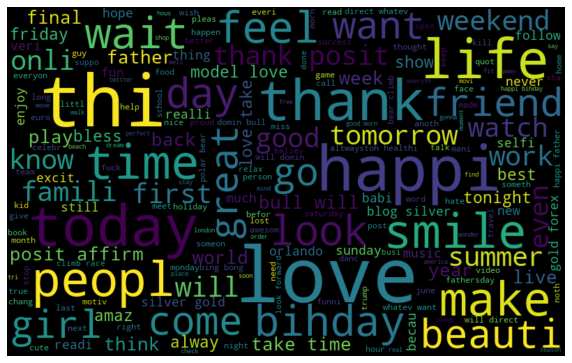

In [34]:
wordcloud_normal = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_normal, interpolation='bilinear')
plt.axis('off')
plt.show()

**A maioria das palavras frequentes é compatível com o sentimento, ou seja, tweets não racistas / sexistas. Da mesma forma, traçaremos a palavra nuvem para o outro sentimento. Espere ver termos negativos, racistas e sexistas.**

#### C) Tweets racistas / sexistas

In [35]:
negative_words = ' '.join( [text for text in combi['tidy_tweet'][combi['label'] == 1]] )

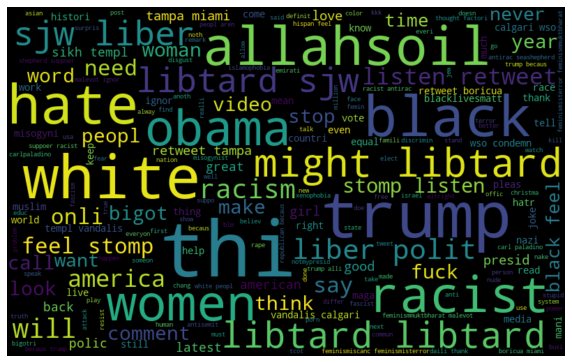

In [36]:
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.show()

**Como podemos ver claramente, a maioria das palavras tem conotações negativas. Portanto, parece que temos dados de texto muito bons para trabalhar. A seguir, veremos as hashtags / tendências em nossos dados do twitter.**

#### D) Entendendo o impacto das Hashtags no sentimento dos tweets

Hashtags no twitter são sinônimos das tendências em andamento no twitter em qualquer momento específico. Devemos tentar verificar se essas hashtags agregam algum valor à nossa tarefa de análise de sentimentos, ou seja, elas ajudam a distinguir os tweets nos diferentes sentimentos.

**Armazenaremos todos os termos de tendência em duas listas separadas - uma para tweets não racistas / sexistas e outra para tweets racistas / sexistas.**

In [37]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [38]:
# Extraindo as hashtags de tweets não racistas/sexistas
HT_regular = hashtag_extract( combi['tidy_tweet'][combi['label'] == 0] )

In [39]:
# Extraindo as hashtags de tweets racistas/sexistas
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

In [40]:
HT_regular = sum(HT_regular, [])

In [41]:
HT_negative = sum(HT_negative, [])

##### Agora que preparamos nossas listas de hashtags para os dois sentimentos, podemos traçar as principais 'n' hashtags. Então, primeiro vamos verificar as hashtags nos tweets não racistas / sexistas.

#### Tweets não-racistas / sexistas

In [42]:
freq_positive = nltk.FreqDist(HT_regular)

In [43]:
df_positive = pd.DataFrame({'hashtag': list(freq_positive.keys()), 'count': list(freq_positive.values())})

In [44]:
df_positive.head()

,hashtag,count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


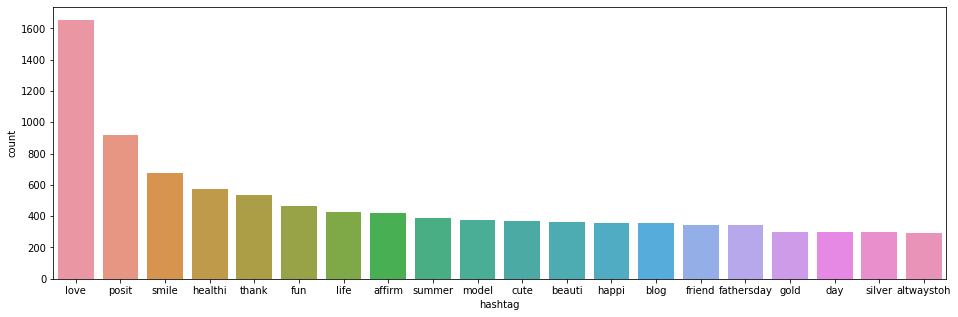

In [45]:
df_positive = df_positive.nlargest(columns='count', n=20)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=df_positive, x='hashtag', y='count')
plt.show()

**Todas essas hashtags são positivas e isso faz sentido. Estou esperando termos negativos no enredo da segunda lista. Vamos verificar as hashtags mais frequentes que aparecem nos tweets racistas / sexistas.**

#### Tweets racistas / sexistas

In [46]:
freq_negative = nltk.FreqDist(HT_negative)

In [47]:
df_negative = pd.DataFrame({'hashtag': list(freq_negative.keys()), 'count': list(freq_negative.values())})

In [48]:
df_negative.head()

,hashtag,count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


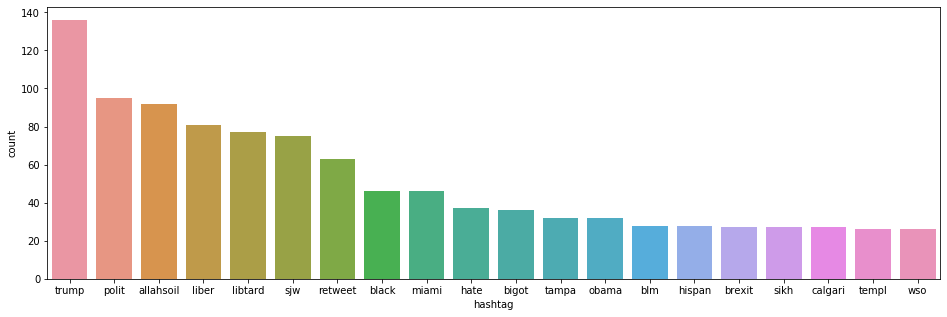

In [49]:
df_negative = df_negative.nlargest(columns='count', n=20)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=df_negative, x='hashtag', y='count')

**Como esperado, a maioria dos termos é negativa com alguns termos neutros também. Portanto, não é uma má idéia manter essas hashtags em nossos dados, pois elas contêm informações úteis. Em seguida, tentaremos extrair recursos dos tweets tokenizados.**

## Bag of Words Features

Para analisar dados pré-processados, eles precisam ser convertidos em recursos. Dependendo do uso, os recursos de texto podem ser construídos usando várias técnicas - **Bag of Words, TF-IDF e Word Embeddings**. Leia para entender essas técnicas em detalhes.
Vamos começar com os  Recursos do Pacote de Palavras .

Considere um Corpus C de D documentos **{d1, d2… ..dD}** e **N tokens** exclusivos extraídos do corpus C. Os N tokens (palavras) formarão um dicionário e o tamanho da matriz de palavras-chave M X N. Cada linha na matriz M contém a frequência de tokens no documento D(i).

Vamos entender isso usando um exemplo simples.

**D1: Ele é um garoto preguiçoso. Ela também é preguiçosa.**

**D2: Smith é uma pessoa preguiçosa.**

O dicionário criado seria uma lista de tokens exclusivos no corpus = **['Ele', 'Ela', 'preguiçoso', 'garoto', 'Smith', 'pessoa']**

Aqui, **D = 2**, **N = 6**

                                        A matriz M de tamanho 2 X 6 será representada como
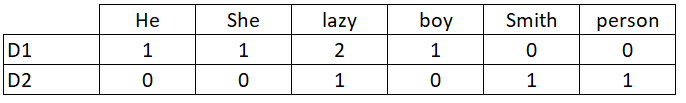

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
bow_vectorizer = CountVectorizer(max_df=.90, min_df=2, max_features=1000, stop_words='english')

In [52]:
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [53]:
bow.shape

(49159, 1000)

## TF-IDF Features

Esse é outro método baseado no método de frequência, mas é diferente da abordagem do bag of words, no sentido de levar em conta não apenas a ocorrência de uma palavra em um único documento (ou tweet), mas em todo o corpus.

O TF-IDF funciona penalizando as palavras comuns, atribuindo-lhes pesos mais baixos, dando importância a palavras raras em todo o corpus, mas que aparecem em bons números em poucos documentos.

Vamos dar uma olhada nos termos importantes relacionados ao TF-IDF:

    TF = (número de vezes que o termo t aparece em um documento) / (número de termos no documento)

    IDF = log (N / n), em que N é o número de documentos e n é o número de documentos em que um termo t apareceu.

    TF-IDF = TF * IDF

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tfidf_vetorizer = TfidfVectorizer(max_df=.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vetorizer.fit_transform(combi['tidy_tweet'])

In [56]:
tfidf.shape

(49159, 1000)

In [57]:
df_positive.head()

,hashtag,count
32,love,1654
39,posit,917
58,smile,676
157,healthi,573
38,thank,534


## Word2Vec Features

Embedding de palavras é a maneira moderna de representar palavras como vetores. O objetivo das combinações de palavras é redefinir os recursos de alta dimensão da palavra em vetores de baixa dimensão, preservando a similaridade contextual no corpus. Eles são capazes de realizar tarefas como King -man + woman = Queen , o que é impressionante.

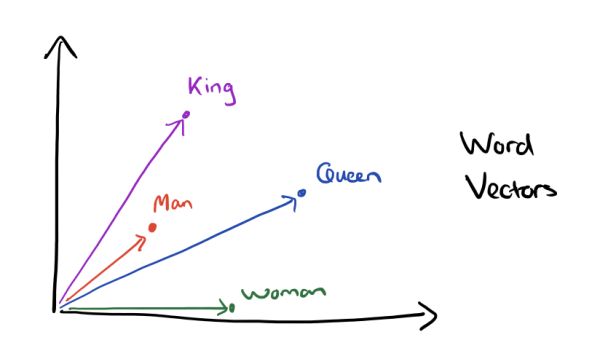

**As vantagens do uso de incorporação de palavras sobre BOW ou TF-IDF são:**

    1 - Redução de dimensionalidade - redução significativa no não. dos recursos necessários para construir um modelo.

    2 - Ele captura significados das palavras, relacionamentos semânticos e os diferentes tipos de contextos em que são usados.




#### 1. Word2Vec Embeddings

O Word2Vec não é um algoritmo único, mas uma combinação de duas técnicas -  **CBOW (Continuous bag of words)** e  **kip-gram model** . Ambas são redes neurais rasas que mapeiam palavras para a variável de destino que também é uma palavra. Ambas as técnicas aprendem pesos que atuam como representações de vetores de palavras.

O CBOW tende a prever a probabilidade de uma palavra em um contexto. Um contexto pode ser uma única palavra adjacente ou um grupo de palavras ao redor. O modelo Skip-gram funciona de maneira inversa, tenta prever o contexto de uma determinada palavra.

Abaixo está uma representação esquemática de um modelo Word2Vec da janela de contexto de 1 palavra.

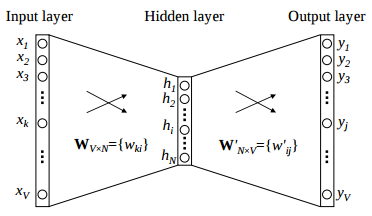

Existem três laters:
- uma camada de entrada 
- uma camada oculta e 
- uma camada de saída.

A camada de entrada e a saída são codificadas em um tamanho quente [1 X V], onde V é o tamanho do vocabulário (número de palavras únicas no corpus). A camada de saída é uma camada softmax que é usada para somar as probabilidades obtidas na camada de saída para 1. Os pesos aprendidos pelo modelo são então usados ​​como vetores de palavras.

**Iremos adiante com o modelo Skip-gram, pois possui as seguintes vantagens:**

    1 - Ele pode capturar duas semânticas para uma única palavra. isto é, terá duas representações vetoriais de 'maçã'. Um para a empresa Apple e outro para a fruta.

    2 - Skip-gram com subamostragem negativa supera o CBOW em geral.

##### Vamos treinar um modelo Word2Vec em nosso corpus.

In [58]:
from gensim.models import Word2Vec

In [59]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

In [60]:
model_w2v = Word2Vec(
    tokenized_tweet,
    size=200,
    window=5,
    min_count=2,
    sg=1,
    hs=0,
    negative=10,
    workers=2,
    seed=34
)

In [61]:
model_w2v.train(tokenized_tweet, total_examples=len(combi['tidy_tweet']), epochs=20)

(6510028, 7536020)

**Especificaremos uma palavra e o modelo retirará as palavras mais semelhantes do corpus.**

In [62]:
model_w2v.wv.most_similar(positive='trump')

[('hillari', 0.5604446530342102),
 ('donald', 0.5535435080528259),
 ('melo', 0.5446593761444092),
 ('phoni', 0.5393862128257751),
 ('unstabl', 0.5337557792663574),
 ('tomlin', 0.5235994458198547),
 ('unfavor', 0.5234707593917847),
 ('unfit', 0.5222508907318115),
 ('#delegaterevolt', 0.522222638130188),
 ('potu', 0.520110011100769)]

**Dos dois exemplos acima, podemos ver que nosso modelo word2vec faz um bom trabalho em encontrar as palavras mais semelhantes para uma determinada palavra. Mas como é capaz de fazer isso? Isso porque aprendeu vetores para cada palavra única em nossos dados e usa a semelhança de cosseno para descobrir os vetores mais semelhantes (palavras).**

Vamos verificar a representação vetorial de qualquer palavra do nosso corpus.

In [63]:
model_w2v['food']

array([ 0.40400356, -0.22590415, -0.67711335, -0.16637109,  0.217357  ,
        0.1638957 , -0.54626065, -0.5069989 ,  0.8901783 , -0.31702164,
       -0.46307617,  0.42177042,  0.39328843,  1.0632478 ,  0.43910846,
        0.2942422 ,  0.18095902,  0.23435305,  0.1388209 ,  0.12185619,
       -0.18726356,  0.76545024, -0.2598335 ,  0.1476965 , -0.28502068,
        0.8155545 , -0.24035114,  0.5077255 , -0.10860551, -0.42283434,
        0.42888632, -1.0099791 , -0.08878346,  0.10241719,  0.63246006,
       -0.40677702, -0.6534437 , -0.15342903, -0.78217804, -0.09172239,
       -0.46099627, -0.69778126, -0.19059893, -0.25856918,  0.06264175,
       -0.06640632,  0.01732609, -0.5815873 ,  0.406519  ,  0.50356036,
        0.225673  ,  0.34661862, -0.07685699, -0.15571654,  0.24411172,
       -0.4559429 ,  0.37784302, -0.10311595,  0.34758615,  0.16378984,
       -0.50171   ,  0.32883197, -0.27921128, -0.01468127, -0.06112793,
        0.39401686,  0.4835313 , -0.52073103,  0.2709518 , -0.49

In [64]:
len(model_w2v['food'])

200

#### Preparando vetores para tweets

Como nossos dados contêm tweets e não apenas palavras, teremos que descobrir uma maneira de usar os vetores de palavras do modelo word2vec para criar representação vetorial para um tweet inteiro. Existe uma solução simples para esse problema, podemos simplesmente significar todos os vetores de palavras presentes no tweet. A duração do vetor resultante será a mesma, ou seja, 200. Repetiremos o mesmo processo para todos os tweets em nossos dados e obteremos seus vetores. Agora, temos 200 recursos word2vec para nossos dados.

Usaremos a função abaixo para criar um vetor para cada tweet, calculando a média dos vetores das palavras presentes no tweet.

In [65]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [66]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

In [67]:
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)

In [68]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.137954,0.294256,-0.077961,-0.318769,0.035686,-0.034940,0.071295,-0.004466,0.069265,-0.114529,...,-0.080337,0.396944,-0.057072,-0.005284,0.204459,0.059338,0.280106,-0.327983,-0.209775,-0.128169
1,0.192997,0.202573,-0.106383,-0.286630,0.124049,-0.295725,-0.056795,-0.099262,-0.053165,0.001370,...,0.068074,0.126937,0.233205,-0.001700,0.205920,0.062239,0.137548,-0.023844,-0.142542,-0.139746
2,0.089984,-0.001766,0.042795,0.118182,0.106712,-0.158802,-0.417204,-0.666483,0.092254,0.032583,...,-0.099779,-0.123803,0.428043,-0.239378,-0.124970,0.393974,0.203472,-0.234299,-0.089713,-0.117172
3,0.342448,0.066053,-0.594384,-0.297312,-0.237051,-0.391661,-0.085049,-0.473441,0.048384,0.124874,...,0.506544,0.147724,0.152837,0.123060,-0.182086,-0.300468,0.365523,-0.106967,-0.291009,-0.061501
4,0.083065,0.008250,-0.503319,-0.542028,0.027004,-0.251708,0.022570,-0.598067,0.178599,-0.145937,...,0.440196,0.293431,0.134985,-0.447823,0.033514,0.259506,-0.204399,-0.186589,0.064403,-0.257689


In [69]:
wordvec_df.shape

(49159, 200)

**Agora, temos 200 novos recursos, enquanto no Bag of Words e no TF-IDF tínhamos 1000 recursos.**

#### 2. Doc2Vec Embedding

O modelo Doc2Vec é um algoritmo não supervisionado para gerar vetores para sentenças / parágrafos / documentos. Essa abordagem é uma extensão da word2vec. A principal diferença entre os dois é que o doc2vec fornece um contexto adicional exclusivo para todos os documentos do corpus. Esse contexto adicional não passa de outro vetor de recurso para todo o documento. Este vetor de documento é treinado junto com os vetores de palavras.

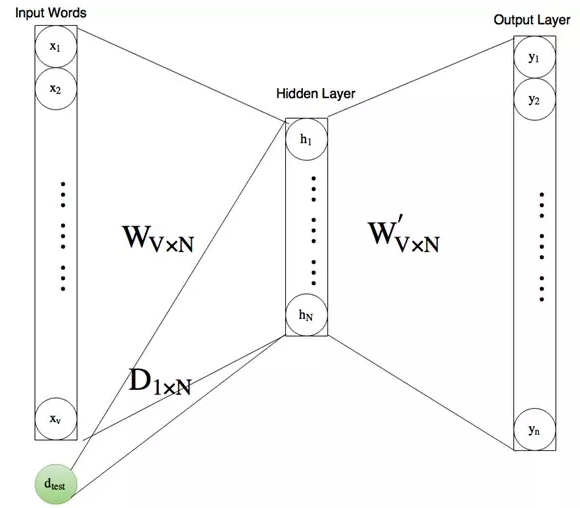

In [70]:
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence

**Para implementar o doc2vec, precisamos rotular ou marcar cada tweet tokenizado com IDs exclusivos. Podemos fazer isso usando a função LabeledSentence() de Gensim .**

In [71]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ['tweet_' + str(i)]))
    return output

In [72]:
labeled_tweets = add_label(tokenized_tweet)

In [73]:
labeled_tweets[:5]

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4'])]

## Agora vamos treinar um modelo doc2vec

In [74]:
from gensim.models import Doc2Vec

In [75]:
model_d2v = Doc2Vec(
    dm=1,
    dm_mean=1,
    vector_size=200,
    window=5,
    negative=7,
    min_count=5,
    workers=3,
    alpha=0.1,
    seed=23
)

In [76]:
model_d2v.build_vocab( [i for i in tqdm(labeled_tweets)] )

100%|██████████| 49159/49159 [00:00<00:00, 461217.60it/s]


In [77]:
model_d2v.train(labeled_tweets, total_examples=len(combi['tidy_tweet']), epochs=15)

#### Preparando o conjunto de recursos do doc2vec

In [78]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

In [79]:
for i in range(len(combi)):
    docvec_arrays[i, :] = model_d2v.docvecs[i].reshape((1, 200))

In [80]:
docvec_df = pd.DataFrame(docvec_arrays)

In [81]:
docvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.166531,-0.019296,0.345060,-0.425077,0.033438,0.279380,-0.153360,0.049775,-0.325928,-0.228263,...,0.169311,0.132967,0.190424,-0.147522,-0.128243,0.070278,-0.060119,0.104930,-0.256303,-0.059592
1,0.179103,-0.023652,-0.115093,0.242792,-0.358075,0.122411,0.065068,0.225603,0.266643,0.147893,...,-0.195857,0.102370,0.153208,-0.075476,0.179551,0.207405,0.101986,-0.128151,-0.079435,-0.022388
2,0.015106,0.129672,-0.149059,-0.031744,-0.009236,-0.060880,0.034542,-0.112771,0.218498,0.038670,...,-0.185171,-0.107213,-0.041709,0.213384,0.053724,0.068496,0.045317,-0.065992,-0.097776,-0.083532
3,-0.011001,0.088342,-0.102581,-0.031799,-0.085939,-0.011887,-0.107528,0.014589,0.262742,0.028683,...,0.031818,-0.138475,-0.046465,0.181639,0.077554,0.061217,0.021546,-0.070211,-0.028145,0.010155
4,-0.042632,0.126843,0.015546,-0.052208,-0.156478,-0.080066,-0.126200,-0.042525,0.266867,-0.042578,...,-0.024579,-0.042514,-0.055087,0.190338,0.169041,0.164490,0.063367,-0.061915,-0.113230,0.050398


In [82]:
docvec_df.shape

(49159, 200)

## Modeling

Agora concluímos todas as etapas de pré-modelagem necessárias para obter os dados no formato e formato adequados. Criaremos modelos nos conjuntos de dados com diferentes conjuntos de recursos preparados nas seções anteriores - **Bag-of-Words, TF-IDF, vetores word2vec e vetores doc2vec**. Usaremos os seguintes algoritmos para criar modelos:

    1.Regressão logística
    2.Máquina de vetores de suporte (SVM - sigla de support vector machine)
    3.RandomForest
    4.XGBoost
    
#### Métrica de Avaliação

**A pontuação F1 está sendo usada como métrica de avaliação**. **É a média ponderada de Precisão e Recuperação**. Portanto, essa pontuação leva em consideração tanto os falsos positivos quanto os falsos negativos. **É adequado para problemas de distribuição de classe desigual.**

Os componentes importantes da pontuação F1 são:

    1.True Positives (TP) - Esses são os valores positivos previstos corretamente, o que significa que o valor da classe real é sim e o valor da classe prevista também é sim.
    2.True Negatives (TN) - Esses são os valores negativos previstos corretamente, o que significa que o valor da classe real é não e o valor da classe prevista também é não.
    3.False Positives (FP) - Quando a classe real é não e a classe prevista é sim.
    4.False Negatives (FN) - Quando a classe real é sim, mas a classe prevista é não.
**Precisão = TP / TP + FP**

**Recall = TP/TP+FN**

**F1 Score = 2(Recall Precision) / (Recall + Precision)**

## Regressão Logística

Regressão logística é um algoritmo de classificação. É usado para prever um resultado binário (1/0, Sim / Não, Verdadeiro / Falso), dado um conjunto de variáveis ​​independentes. Você também pode pensar em regressão logística como um caso especial de regressão linear quando a variável de resultado é categórica, onde estamos usando o log de chances como a variável dependente. Em palavras simples, ele prevê a probabilidade de ocorrência de um evento ajustando dados a uma função de logit.

A seguinte equação é usada em Regressão logística:

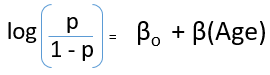

Um gráfico típico do modelo logístico é mostrado abaixo. Você pode ver que a probabilidade nunca fica abaixo de 0 e acima de 1.

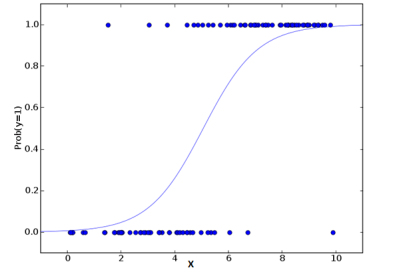

##### Bag-of-Words Features

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [84]:
train_bow = bow[:31962, :]
test_bow = bow[31962:, :]

In [85]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(train_bow, train['label'],test_size=.3, random_state=42)

In [86]:
lr = LogisticRegression()

In [87]:
lr.fit(X_train_bow, y_train)

/home/igobarros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
pred = lr.predict_proba(X_test_bow)

In [89]:
pred_int = pred[:, 1] >= 0.3

In [90]:
pred_int = pred_int.astype(np.int)

In [91]:
f1_score(y_test, pred_int)

0.5307820299500832

**Agora vamos fazer previsões para o conjunto de dados de teste e criar um arquivo de envio.**

In [92]:
test_pred = lr.predict_proba(test_bow)

In [93]:
test_pred_int = test_pred[:, 1] >= 0.3

In [94]:
test_pred_int = test_pred_int.astype(np.int)

In [95]:
test['label'] = test_pred_int

In [96]:
submission = test[['id', 'label']]

In [97]:
submission.to_csv('sub_lr_bow.csv', index=False)

#### TF-IDF Features

Seguiremos os mesmos passos acima, mas agora para o conjunto de recursos TF-IDF.

In [98]:
train_tfidf = tfidf[:31962, :]
test_tfidf = tfidf[31962:, :]

In [99]:
X_train_tfidf = train_tfidf[y_train.index]
X_test_tfidf = train_tfidf[y_test.index]

In [100]:
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
pred = lr.predict_proba(X_test_tfidf)

In [102]:
pred_int = pred[:, 1] >= 0.3

In [103]:
pred_int = pred_int.astype(np.int)

In [104]:
f1_score(y_test, pred_int)

0.5446507515473032

#### Word2Vec Features

In [105]:
train_w2v = wordvec_df.iloc[:31962, :]
test_w2v = wordvec_df.iloc[31962:, :]

In [106]:
X_train_w2v = train_w2v.iloc[y_train.index, :]
X_test_w2v = train_w2v.iloc[y_test.index, :]

In [107]:
lr.fit(X_train_w2v, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
pred = lr.predict_proba(X_test_w2v)

In [109]:
pred_int = pred[:, 1] >= 0.3

In [110]:
pred_int = pred_int.astype(np.int)

In [111]:
f1_score(y_test, pred_int)

0.61880088823094

#### Doc2Vec Features

In [112]:
train_d2v = docvec_df.iloc[:31962,:] 
test_d2v = docvec_df.iloc[31962:,:]

In [113]:
X_train_d2v = train_d2v.iloc[y_train.index,:] 
X_test_d2v = train_d2v.iloc[y_test.index,:]

In [114]:
lr.fit(X_train_d2v, y_train)

/home/igobarros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
pred = lr.predict_proba(X_test_d2v) 

In [116]:
pred_int = pred[:,1] >= 0.3 
pred_int = pred_int.astype(np.int) 

In [117]:
f1_score(y_test, pred_int)

0.3761702127659574

## Support Vector Machine (SVM)

O SVM (Support Vector Machine) é um algoritmo de aprendizado de máquina supervisionado que pode ser usado para desafios de classificação ou regressão. No entanto, é usado principalmente em problemas de classificação. Nesse algoritmo, plotamos cada item de dados como um ponto no espaço n-dimensional (onde n é o número de recursos que você possui), com o valor de cada recurso sendo o valor de uma determinada coordenada. Em seguida, realizamos a classificação encontrando o hiperplano que diferencia as duas classes, conforme mostrado no gráfico abaixo:

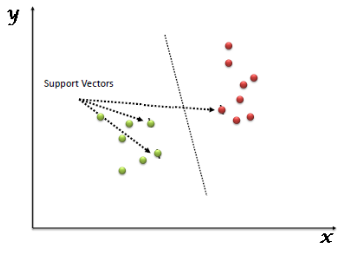

#### Bag-of-Words Features

In [118]:
from sklearn.svm import SVC

In [119]:
svc = SVC(kernel='linear', C=1, probability=True).fit(X_train_bow, y_train)

In [120]:
pred = svc.predict_proba(X_test_bow)

In [121]:
pred_int = pred[:, 1] >= 0.3

In [122]:
pred_int = pred_int.astype(np.int)

In [123]:
f1_score(y_test, pred_int)

0.5083798882681564

**Novamente, vamos fazer previsões para o conjunto de dados de teste e criar outro arquivo de envio.**

In [124]:
test_pred = svc.predict_proba(test_bow)

In [125]:
test_pred_int = test_pred[:, 1] >= 0.3

In [126]:
test_pred_int = test_pred_int.astype(np.int)

In [127]:
test['label'] = test_pred_int

In [128]:
submission = test[['id', 'label']]

In [129]:
submission.to_csv('sub_svm_bow.csv', index=False)

#### TF-IDF Features

In [130]:
svc = SVC(kernel='linear', C=1, probability=True).fit(X_train_tfidf, y_train)

In [131]:
pred = svc.predict_proba(X_test_tfidf)

In [132]:
pred_int = pred[:, 1] >= 0.3

In [133]:
pred_int = pred_int.astype(np.int)

In [134]:
f1_score(y_test, pred_int)

0.5104831358249772

#### Word2Vec Features

In [135]:
svc = SVC(kernel='linear', C=1, probability=True).fit(X_train_w2v, y_train)

In [136]:
pred = svc.predict_proba(X_test_w2v)

In [137]:
pred_int = pred[:, 1] >= 0.3

In [138]:
pred_int = pred_int.astype(np.int)

In [139]:
f1_score(y_test, pred_int)

0.6107594936708861

#### Doc2Vec Features

In [140]:
svc = SVC(kernel='linear', C=1, probability=True).fit(X_train_d2v, y_train)

In [141]:
pred = svc.predict_proba(X_test_d2v)

In [142]:
pred_int = pred[:, 1] >= 0.3

In [143]:
pred_int = pred_int.astype(np.int)

In [144]:
f1_score(y_test, pred_int)

0.2836734693877551

## RandomForest

O **Random Forest** é um algoritmo versátil de aprendizado de máquina capaz de executar tarefas de regressão e classificação. É um tipo de método de aprendizado de conjunto, em que alguns modelos fracos se combinam para formar um modelo poderoso. Na Floresta Aleatória, crescemos várias árvores em oposição a uma única árvore de decisão. Para classificar um novo objeto com base em atributos, cada árvore dá uma classificação e dizemos que a árvore **“vota”** para essa classe. A floresta escolhe a classificação com mais votos (sobre todas as árvores da floresta).

**Funciona da seguinte maneira. Cada árvore é plantada e cultivada da seguinte forma:**

    1.Suponha que o número de casos no conjunto de treinamento seja N. Em seguida, uma amostra desses N casos é coletada aleatoriamente, mas com substituição. Esta amostra será o conjunto de treinamento para o cultivo da árvore.

    2.Se houver M variáveis ​​de entrada, um número m (m<M) é especificado de modo que, em cada nó, m variáveis ​​sejam selecionadas aleatoriamente dentre M. A melhor divisão nessas m variáveis ​​é usada para dividir o nó. O valor de m é mantido constante enquanto cultivamos a floresta.

    3.Cada árvore é cultivada na maior extensão possível e não há poda.

    4.Preveja novos dados agregando as previsões das árvores ntree (ou seja, maioria dos votos para classificação, média para regressão).
    
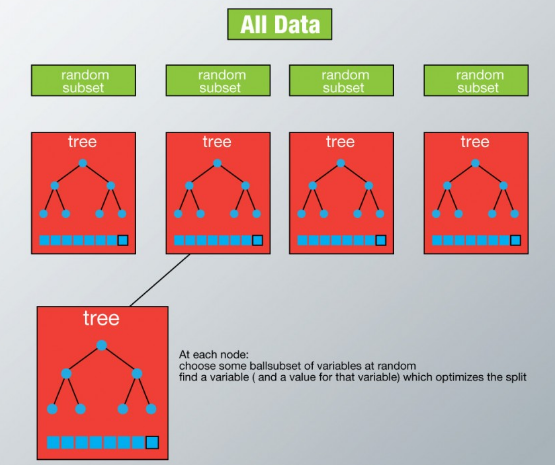

#### Bag-of-Words Features

In [145]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train_bow, y_train)

In [147]:
pred = rf.predict(X_test_bow)

In [148]:
f1_score(y_test, pred)

0.5529225908372828

**Vamos fazer previsões para o conjunto de dados de teste e criar outro arquivo de envio.**

In [149]:
test_pred = rf.predict(test_bow)

In [150]:
test['label'] = test_pred

In [151]:
submission = test[['id', 'label']]

In [152]:
submission.to_csv('sub_rf_bow.csv', index=False)

#### TF-IDF Features

In [153]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train_tfidf, y_train)

In [154]:
pred = rf.predict(X_test_tfidf)

In [155]:
f1_score(y_test, pred)

0.562152133580705

#### Word2Vec Features

In [156]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train_w2v, y_train)

In [157]:
pred = rf.predict(X_test_w2v)

In [158]:
f1_score(y_test, pred)

0.49620801733477793

#### Doc2Vec Features

In [159]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train_d2v, y_train)

In [160]:
pred = rf.predict(X_test_d2v)

In [161]:
f1_score(y_test, pred)

0.08926080892608089

## XGBoost

O Extreme Gradient Boosting (xgboost) é uma implementação avançada do algoritmo de aumento de gradiente. Possui algoritmos de resolução de modelo linear e de aprendizado de árvore. Sua capacidade de fazer computação paralela em uma única máquina torna-a extremamente rápida. Ele também possui recursos adicionais para validação cruzada e localização de variáveis ​​importantes. Existem muitos parâmetros que precisam ser controlados para otimizar o modelo.

Alguns dos principais benefícios do XGBoost são:

    1.Regularization - ajuda a reduzir o sobreajuste

    2.Parallel Processing - O XGBoost implementa o processamento paralelo e é incrivelmente mais rápido em comparação com o GBM.

    3.Handling Missing Values - Possui uma rotina integrada para manipular valores ausentes.

    4.Built-in Cross-Validation - permite ao usuário executar uma validação cruzada a cada iteração do processo de otimização

#### Bag-of-Words Features

In [162]:
from xgboost import XGBClassifier

In [163]:
xgb_model = XGBClassifier(max_deph=6, n_estimators=1000).fit(X_train_bow, y_train)

In [164]:
pred = xgb_model.predict(X_test_bow)

In [165]:
f1_score(y_test, pred)

0.49550449550449543

**Vamos fazer previsões para o conjunto de dados de teste e criar outro arquivo de envio.**

In [166]:
test_pred = xgb_model.predict(test_bow)

In [167]:
test['label'] = test_pred

In [168]:
submission = test[['id', 'label']]

In [169]:
submission.to_csv('sub_xgb_bow.csv', index=False)

#### TF-IDF Features

In [170]:
xgb_model = XGBClassifier(max_deph=6, n_estimators=1000).fit(X_train_tfidf, y_train)

In [171]:
pred = xgb_model.predict(X_test_tfidf)

In [172]:
f1_score(y_test, pred)

0.5054945054945055

#### Word2Vec Features

In [173]:
xgb_model = XGBClassifier(max_deph=6, n_estimators=1000, nthread=3).fit(X_train_w2v, y_train)

In [174]:
pred = xgb_model.predict(X_test_w2v)

In [175]:
f1_score(y_test, pred)

0.6422836752899197

**O modelo XGBoost com Word2Vec features superou todos os modelos anteriores com esta base de dados.**

#### Doc2Vec Features

In [176]:
xgb_model = XGBClassifier(max_deph=6, n_estimators=1000, nthread=3).fit(X_train_d2v, y_train)

In [177]:
pred = xgb_model.predict(X_test_d2v)

In [178]:
f1_score(y_test, pred)

0.34291799787007454

## FineTuning XGBoost + Word2Vec

**O XGBoost com o modelo Word2Vec nos deu o melhor desempenho até agora. Vamos tentar ajustá-lo ainda mais para extrair o máximo possível dele. O XGBoost possui muitos parâmetros de ajuste e, às vezes, torna-se complicado ajustá-los adequadamente. É isso que vamos fazer nas etapas a seguir.**

In [179]:
import xgboost as xgb

In [180]:
d_train = xgb.DMatrix(X_train_w2v, label=y_train)
d_valid = xgb.DMatrix(X_test_w2v, label=y_test)
d_test = xgb.DMatrix(test_w2v)

/home/igobarros/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [181]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1
}

**Prepararemos uma métrica de avaliação personalizada para calcular a pontuação F1.**

In [182]:
def custom_eval(preds, d_train):
    labels = d_train.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

#### Abordagem geral para ajuste de parâmetros

Seguiremos as etapas abaixo para ajustar os parâmetros.

    1.Escolha uma taxa de aprendizado relativamente alta. Normalmente, uma taxa de aprendizado de 0,3 é usada nesta fase.

    2.Ajuste parâmetros específicos da árvore, como max_depth, min_child_weight, subsample, colsample_bytree, mantendo a taxa de aprendizado fixa.

    3.Ajuste a taxa de aprendizado.

    4.Finalmente, ajuste a gama para evitar ajustes excessivos.

In [201]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6, 10)
    for min_child_weight in range(5, 8)
]

In [202]:
max_f1 = 0.
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print('CV with max_depth = {}, min_child_weight = {}'.format(max_depth, min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(
        params,
        d_train,
        feval=custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].values.argmax()

    print('\tF1 Score {} for {} rounds'.format(mean_f1, boost_rounds))

    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth, min_child_weight)
    
print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth = 6, min_child_weight = 5
	F1 Score 0.6779688 for 78 rounds
CV with max_depth = 6, min_child_weight = 6
	F1 Score 0.6695741999999999 for 75 rounds
CV with max_depth = 6, min_child_weight = 7
	F1 Score 0.6666953999999999 for 51 rounds
CV with max_depth = 7, min_child_weight = 5
	F1 Score 0.6825248 for 74 rounds
CV with max_depth = 7, min_child_weight = 6
	F1 Score 0.6768492000000002 for 68 rounds
CV with max_depth = 7, min_child_weight = 7
	F1 Score 0.6695376000000001 for 42 rounds
CV with max_depth = 8, min_child_weight = 5
	F1 Score 0.6712022 for 64 rounds
CV with max_depth = 8, min_child_weight = 6
	F1 Score 0.6760238000000001 for 43 rounds
CV with max_depth = 8, min_child_weight = 7
	F1 Score 0.6724002 for 67 rounds
CV with max_depth = 9, min_child_weight = 5
	F1 Score 0.6650494 for 25 rounds
CV with max_depth = 9, min_child_weight = 6
	F1 Score 0.6719552 for 53 rounds
CV with max_depth = 9, min_child_weight = 7
	F1 Score 0.6738072 for 78 rounds
Best params: 7, 5, 

**Atualizando max_depth e min_child_weight parâmetros.**

In [185]:
params['max_depth'] = 7
params['min_child_weight'] = 5

**Sintonização subamostra e colsample**

In [204]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] 
]

In [208]:
max_f1 = 0. 
best_params = None 
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(subsample, colsample))
    
    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample
    
    cv_results = xgb.cv(
        params,
        d_train,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )
    
     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].values.argmax()
    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample) 

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
	F1 Score 0.647937 for 48 rounds
CV with subsample=0.5, colsample=0.6
	F1 Score 0.647937 for 48 rounds
CV with subsample=0.5, colsample=0.7
	F1 Score 0.647937 for 48 rounds
CV with subsample=0.5, colsample=0.8
	F1 Score 0.647937 for 48 rounds
CV with subsample=0.5, colsample=0.9
	F1 Score 0.647937 for 48 rounds
CV with subsample=0.6, colsample=0.5
	F1 Score 0.6571818 for 45 rounds
CV with subsample=0.6, colsample=0.6
	F1 Score 0.6571818 for 45 rounds
CV with subsample=0.6, colsample=0.7
	F1 Score 0.6571818 for 45 rounds
CV with subsample=0.6, colsample=0.8
	F1 Score 0.6571818 for 45 rounds
CV with subsample=0.6, colsample=0.9
	F1 Score 0.6571818 for 45 rounds
CV with subsample=0.7, colsample=0.5
	F1 Score 0.6458254 for 36 rounds
CV with subsample=0.7, colsample=0.6
	F1 Score 0.6458254 for 36 rounds
CV with subsample=0.7, colsample=0.7
	F1 Score 0.6458254 for 36 rounds
CV with subsample=0.7, colsample=0.8
	F1 Score 0.6458254 for 36 rounds
CV with sub

**Atualizando subamostra e colsample_bytree**

In [186]:
params['subsample'] = .9
params['colsample_bytree'] = .5

In [184]:
max_f1 = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print('CV with eta={}'.format(eta))
    
    # Update Eta
    params['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        feval=custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )
    
    # Fiding best F1 score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].values.argmax()
    
    print('\tF1 Score {} for {} rounds'.format(mean_f1, boost_rounds))
    
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta

print('Best params: {}, F1 Score: {}'.format(best_params, max_f1))

CV with eta=0.3
	F1 Score 0.6789780000000001 for 85 rounds
CV with eta=0.2
	F1 Score 0.6871204000000001 for 103 rounds
CV with eta=0.1
	F1 Score 0.6731842 for 97 rounds
CV with eta=0.05
	F1 Score 0.6820655999999999 for 214 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.2, F1 Score: 0.6871204000000001


**Vamos dar uma olhada na lista final de parâmetros ajustados.**

In [183]:
params['eta'] = 0.2

In [202]:
# Parâmetro adicional
params['colsample'] = 0.9

In [203]:
params

{'objective': 'binary:logistic',
 'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.2,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'colsample': 0.9}

**Finalmente, agora podemos usar esses parâmetros ajustados em nosso modelo xgboost. Usamos a parada antecipada de 10, o que significa que, se o desempenho do modelo não melhorar em menos de 10 rodadas, o treinamento do modelo será interrompido.**

In [204]:
xgb_model = xgb.train(
    params,
    d_train,
    feval=custom_eval,
    num_boost_round=1000,
    maximize=True,
    evals=[(d_valid, 'Validation')],
    early_stopping_rounds=10
)

[0]	Validation-error:0.063927	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.058087	Validation-f1_score:0.133165
[2]	Validation-error:0.057775	Validation-f1_score:0.36177
[3]	Validation-error:0.05694	Validation-f1_score:0.447598
[4]	Validation-error:0.05621	Validation-f1_score:0.506684
[5]	Validation-error:0.055585	Validation-f1_score:0.526545
[6]	Validation-error:0.054333	Validation-f1_score:0.551193
[7]	Validation-error:0.055167	Validation-f1_score:0.539255
[8]	Validation-error:0.054646	Validation-f1_score:0.563358
[9]	Validation-error:0.05402	Validation-f1_score:0.559738
[10]	Validation-error:0.053082	Validation-f1_score:0.567139
[11]	Validation-error:0.052247	Validation-f1_score:0.561139
[12]	Validation-error:0.052769	Validation-f1_score:0.57596
[13]	Validation-error:0.051935	Validation-f1_score:0.571189
[14]	Validat

**Vamos preparar um arquivo final de envio.**

In [205]:
test_pred = xgb_model.predict(d_test)

In [206]:
test['label'] = (test_pred >= 0.3).astype(np.int)

In [207]:
submission = test[['id', 'label']]

In [208]:
submission.to_csv('sub_xgb_w2v_finetuned.csv', index=False)